#Connecting to google-drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Dataset Link
[Click here for Dataset Acquisition](https://universe.roboflow.com/abhijith-m-czikf/pdflayoutdetection/dataset/20)


The dataset was uploaded to google-drive

#Definig dataset path at google-drive

In [ ]:
DATASET_PATH = '/content/gdrive/MyDrive/ANN-assignment/dataset'

#Installing Ulatralytics EasyOCR

In [ ]:
%%shell
# # to be run only when training
git clone https://github.com/ultralytics/ultralytics.git

pip install ultralytics easyocr

Cloning into 'ultralytics'...
remote: Enumerating objects: 17208, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 17208 (delta 43), reused 60 (delta 15), pack-reused 17088
Receiving objects: 100% (17208/17208), 9.14 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (11985/11985), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 40.0 MB/s eta 0:00:00


#Reading the Dataset


In [ ]:
!cat /content/gdrive/MyDrive/ANN-assignment/dataset/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['block', 'block_h', 'block_wh']

roboflow:
  workspace: abhijith-m-czikf
  project: pdflayoutdetection
  version: 20
  license: CC BY 4.0
  url: https://universe.roboflow.com/abhijith-m-czikf/pdflayoutdetection/dataset/20

#Training the Model

In [ ]:
%%shell
# only to be run when training
yolo task=detect \
    mode=train \
    model=yolov8l.pt \
    data=/content/gdrive/MyDrive/ANN-assignment/dataset/data.yaml \
    epochs=30

100% 83.7M/83.7M [00:00<00:00, 278MB/s]
Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/gdrive/MyDrive/ANN-assignment/dataset/data.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None,

#Creating Reuired Directories

In [ ]:
# only execute when training for the first time
%%shell
mkdir -p /content/gdrive/MyDrive/resumeRoboflow
cp -r /content/ultralytics /content/gdrive/MyDrive/resumeRoboflow
cp -r /content/runs /content/gdrive/MyDrive/resumeRoboflow/ultralytics

In [ ]:
%%shell
yolo task=detect mode=predict model='/content/runs/detect/train/weights/best.pt' \
    source='/content/gdrive/MyDrive/ANN-assignment/dataset/valid/images/Pdf_7311-0_jpg.rf.fabd48c0321571f6bd7370bd279f94b6.jpg'

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43608921 parameters, 0 gradients, 164.8 GFLOPs

image 1/1 /content/gdrive/MyDrive/ANN-assignment/dataset/valid/images/Pdf_7311-0_jpg.rf.fabd48c0321571f6bd7370bd279f94b6.jpg: 640x512 6 blocks, 1 block_h, 127.8ms
Speed: 3.1ms preprocess, 127.8ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 512)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
%%shell
# load the model from the gdrive
#rm -rf /content/ultralytics/ || true
cp -r /content/gdrive/MyDrive/resumeRoboflow/ultralytics /content

#Model usage
Use of the trained model in order to segment different regions of a resume file

In [ ]:
!pip install easyocr ultralytics

In [ ]:
import easyocr
from PIL import Image
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import io
import random as rd
import pprint

pp = pprint.PrettyPrinter(indent=4)

#Utility functions


In [ ]:
# useful for noisy images where the image is denoised
def preProcessImage(img):
    # img = cv2.imread(imgSrc)
    noiseReduced = cv2.fastNlMeansDenoisingColored(img,None, 10, 10, 7, 21)
    noiseReduced = cv2.cvtColor(noiseReduced, cv2.COLOR_BGR2GRAY)
    return noiseReduced

# used to annotate the different regions identified by the model
def annotateImages(oldImg, boxes):
    img = oldImg.copy()

    for box in boxes:
        cords = box.xyxy[0].tolist()
        x1, y1, x2, y2 = list(map(int, cords))

        randCol = (rd.randint(0, 255), rd.randint(0, 255), rd.randint(0, 255))
        img = cv2.rectangle(img, (x1, y1), (x2, y2), randCol, thickness= 2)
    return img

In [ ]:
model = YOLO("/content/ultralytics/runs/detect/train/weights/best.pt")
reader = easyocr.Reader(['en'], gpu=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:

def getAnnotatedImageAndResult(image, preProcess = False):

    if preProcess:
        image = preProcessImage(image)

    results = model.predict(source=image)

    boxes = results[0].boxes
    final_results = []
    img = image.copy()

    for box in boxes:

        # crop each box
        cords = box.xyxy[0].tolist()
        x1, y1, x2, y2 = list(map(int, cords))
        # x1, y1, x2, y2 = box.xyxy[0].tolist()

        cropped = image[y1:y2, x1:x2]

        randCol = (rd.randint(0, 255), rd.randint(0, 255), rd.randint(0, 255))
        img = cv2.rectangle(img, (x1, y1), (x2, y2), randCol, thickness= 2)

        # run OCR on each cropped box and match with the class name
        temp = reader.readtext(np.array(cropped), detail=0)
        if temp:
            final_results.append(temp)

    return img, final_results

Now, lets take two random resume from the dataset and see how the model identifies the regions.

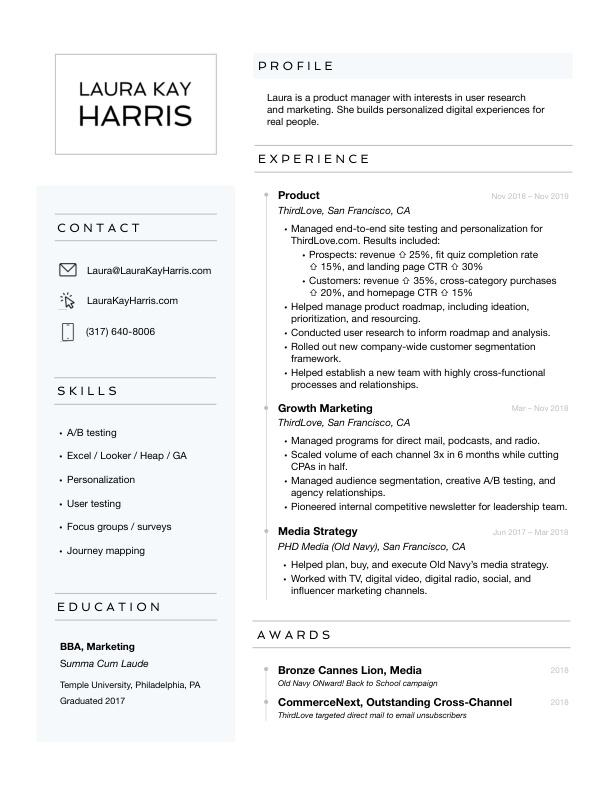

In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/ANN-assignment/dataset/valid/images/Pdf_7311-0_jpg.rf.fabd48c0321571f6bd7370bd279f94b6.jpg')

cv2_imshow(img)

In [ ]:
results = model.predict(source=img)
results


0: 640x512 6 blocks, 1 block_h, 134.6ms
Speed: 5.1ms preprocess, 134.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 512)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'block', 1: 'block_h', 2: 'block_wh'}
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
 


0: 640x512 6 blocks, 1 block_h, 47.3ms
Speed: 12.7ms preprocess, 47.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)


[   [   'EXPERIENCE',
        'Product',
        'Nc, 2UC',
        'e',
        'Thirollove',
        'San Francisco, CA',
        'Managed end-to-end site',
        'parsoralization for',
        'Thirdloic',
        'Com',
        'Rasults ircludad:',
        'Prospects:',
        'ravanue',
        '2594 , fit',
        'como',
        'ation rate',
        'landing page CTR',
        'Customers: revanje',
        '3536.',
        'Cmose',
        'category purchasas',
        '209 ,',
        'homepage CTR',
        '1590',
        'Helped',
        'manage product rcadmap',
        'inc luding',
        'Jabticn',
        'prioritization,',
        'wnd rejoucino',
        'Conduzted user research',
        'infcrm roadmap and analysis',
        'Rollad Oulnew',
        'company-wide',
        'custamar',
        'segmentaticn',
        'Framev Grk',
        'Helped establsh',
        'adr',
        'with highly cross-functional',
        'crocesses',
        'and relatianshicg',

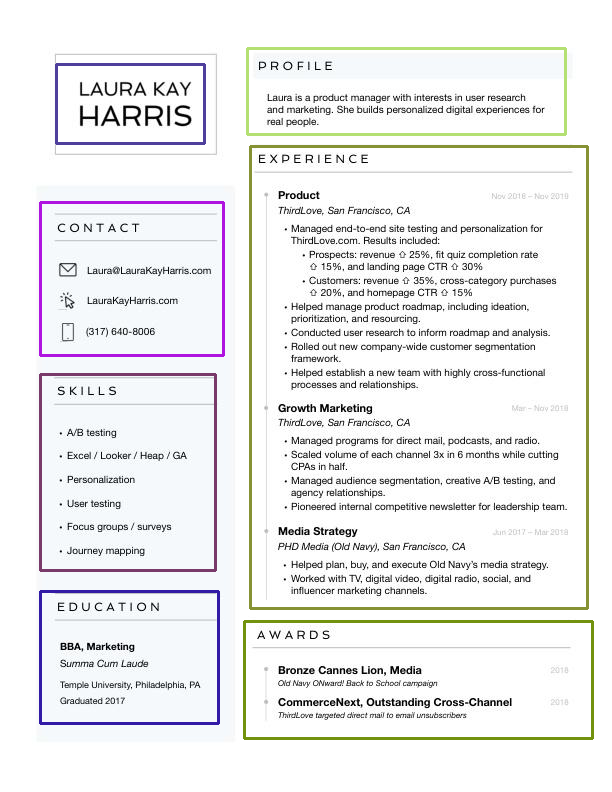

In [ ]:
annotImg, result = getAnnotatedImageAndResult(img)

pp.pprint(result)
cv2_imshow(annotImg)


0: 640x512 7 blocks, 2 block_hs, 1 block_wh, 72.1ms
Speed: 3.5ms preprocess, 72.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)


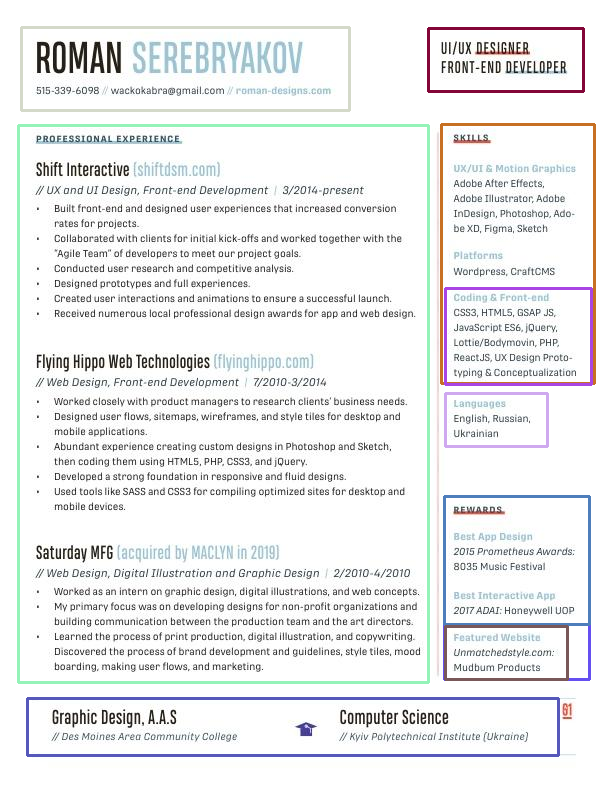

[['PROFESSIONAL EXPERIENCE',
  'Shift Interactive (shiftdsm Com)',
  'I/ UX ond UI Design, Front-end Development',
  '3/2014-present',
  'Builtiruni-end and desigred user',
  'expBrence ?',
  'Inal Mncruasud Lonvursion',
  'rates fur projects',
  'Collaboraledwlln cllents fur Initialkick-ulls andwurked together with the',
  'Agile Team',
  'uevelopers [0 me@',
  'project goals',
  'ConducledUsuT',
  'esearch and compelitive analvsis',
  'Designed protoly',
  'JS; angeuilexueriences',
  'Crealbd user',
  'aclons and animnalions',
  'usure',
  'sulcuSSiu',
  'launch:',
  'Recuived numOrOUS local',
  'Drolessiona',
  'desiyn awarusior app andweb design:',
  'Flying Hippo Web Technologies (flyinghippo com)',
  'Web Design, Front end Developmenr',
  '7/2010-3/2014',
  'Woreed clnselwh',
  'Prouuct managers',
  'Tesuarda',
  "clierts' busiess needs",
  'Desiuned user Iluvs',
  'Gilumaps',
  'wirelrames, and style Llles for desktop and',
  'miobile applicallons:',
  'Abungani exuur Jence crea

In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/ANN-assignment/dataset/valid/images/Pdf_14043-0_jpg.rf.eadbd297333f38c790b50c7dab7e8a10.jpg')

# cv2_imshow(img)
annotImg, result = getAnnotatedImageAndResult(img)

cv2_imshow(annotImg)
result

As we can see, the regions and text are well separated from the resume.

In [ ]:
%%shell
pip install pdf2image
apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.2 [186 kB]
Fetched 186 kB in 1s (135 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.2_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.2) ...
Setting up poppler-utils (22.02.0-2ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...


Now let us check the model in a completely new data for validation

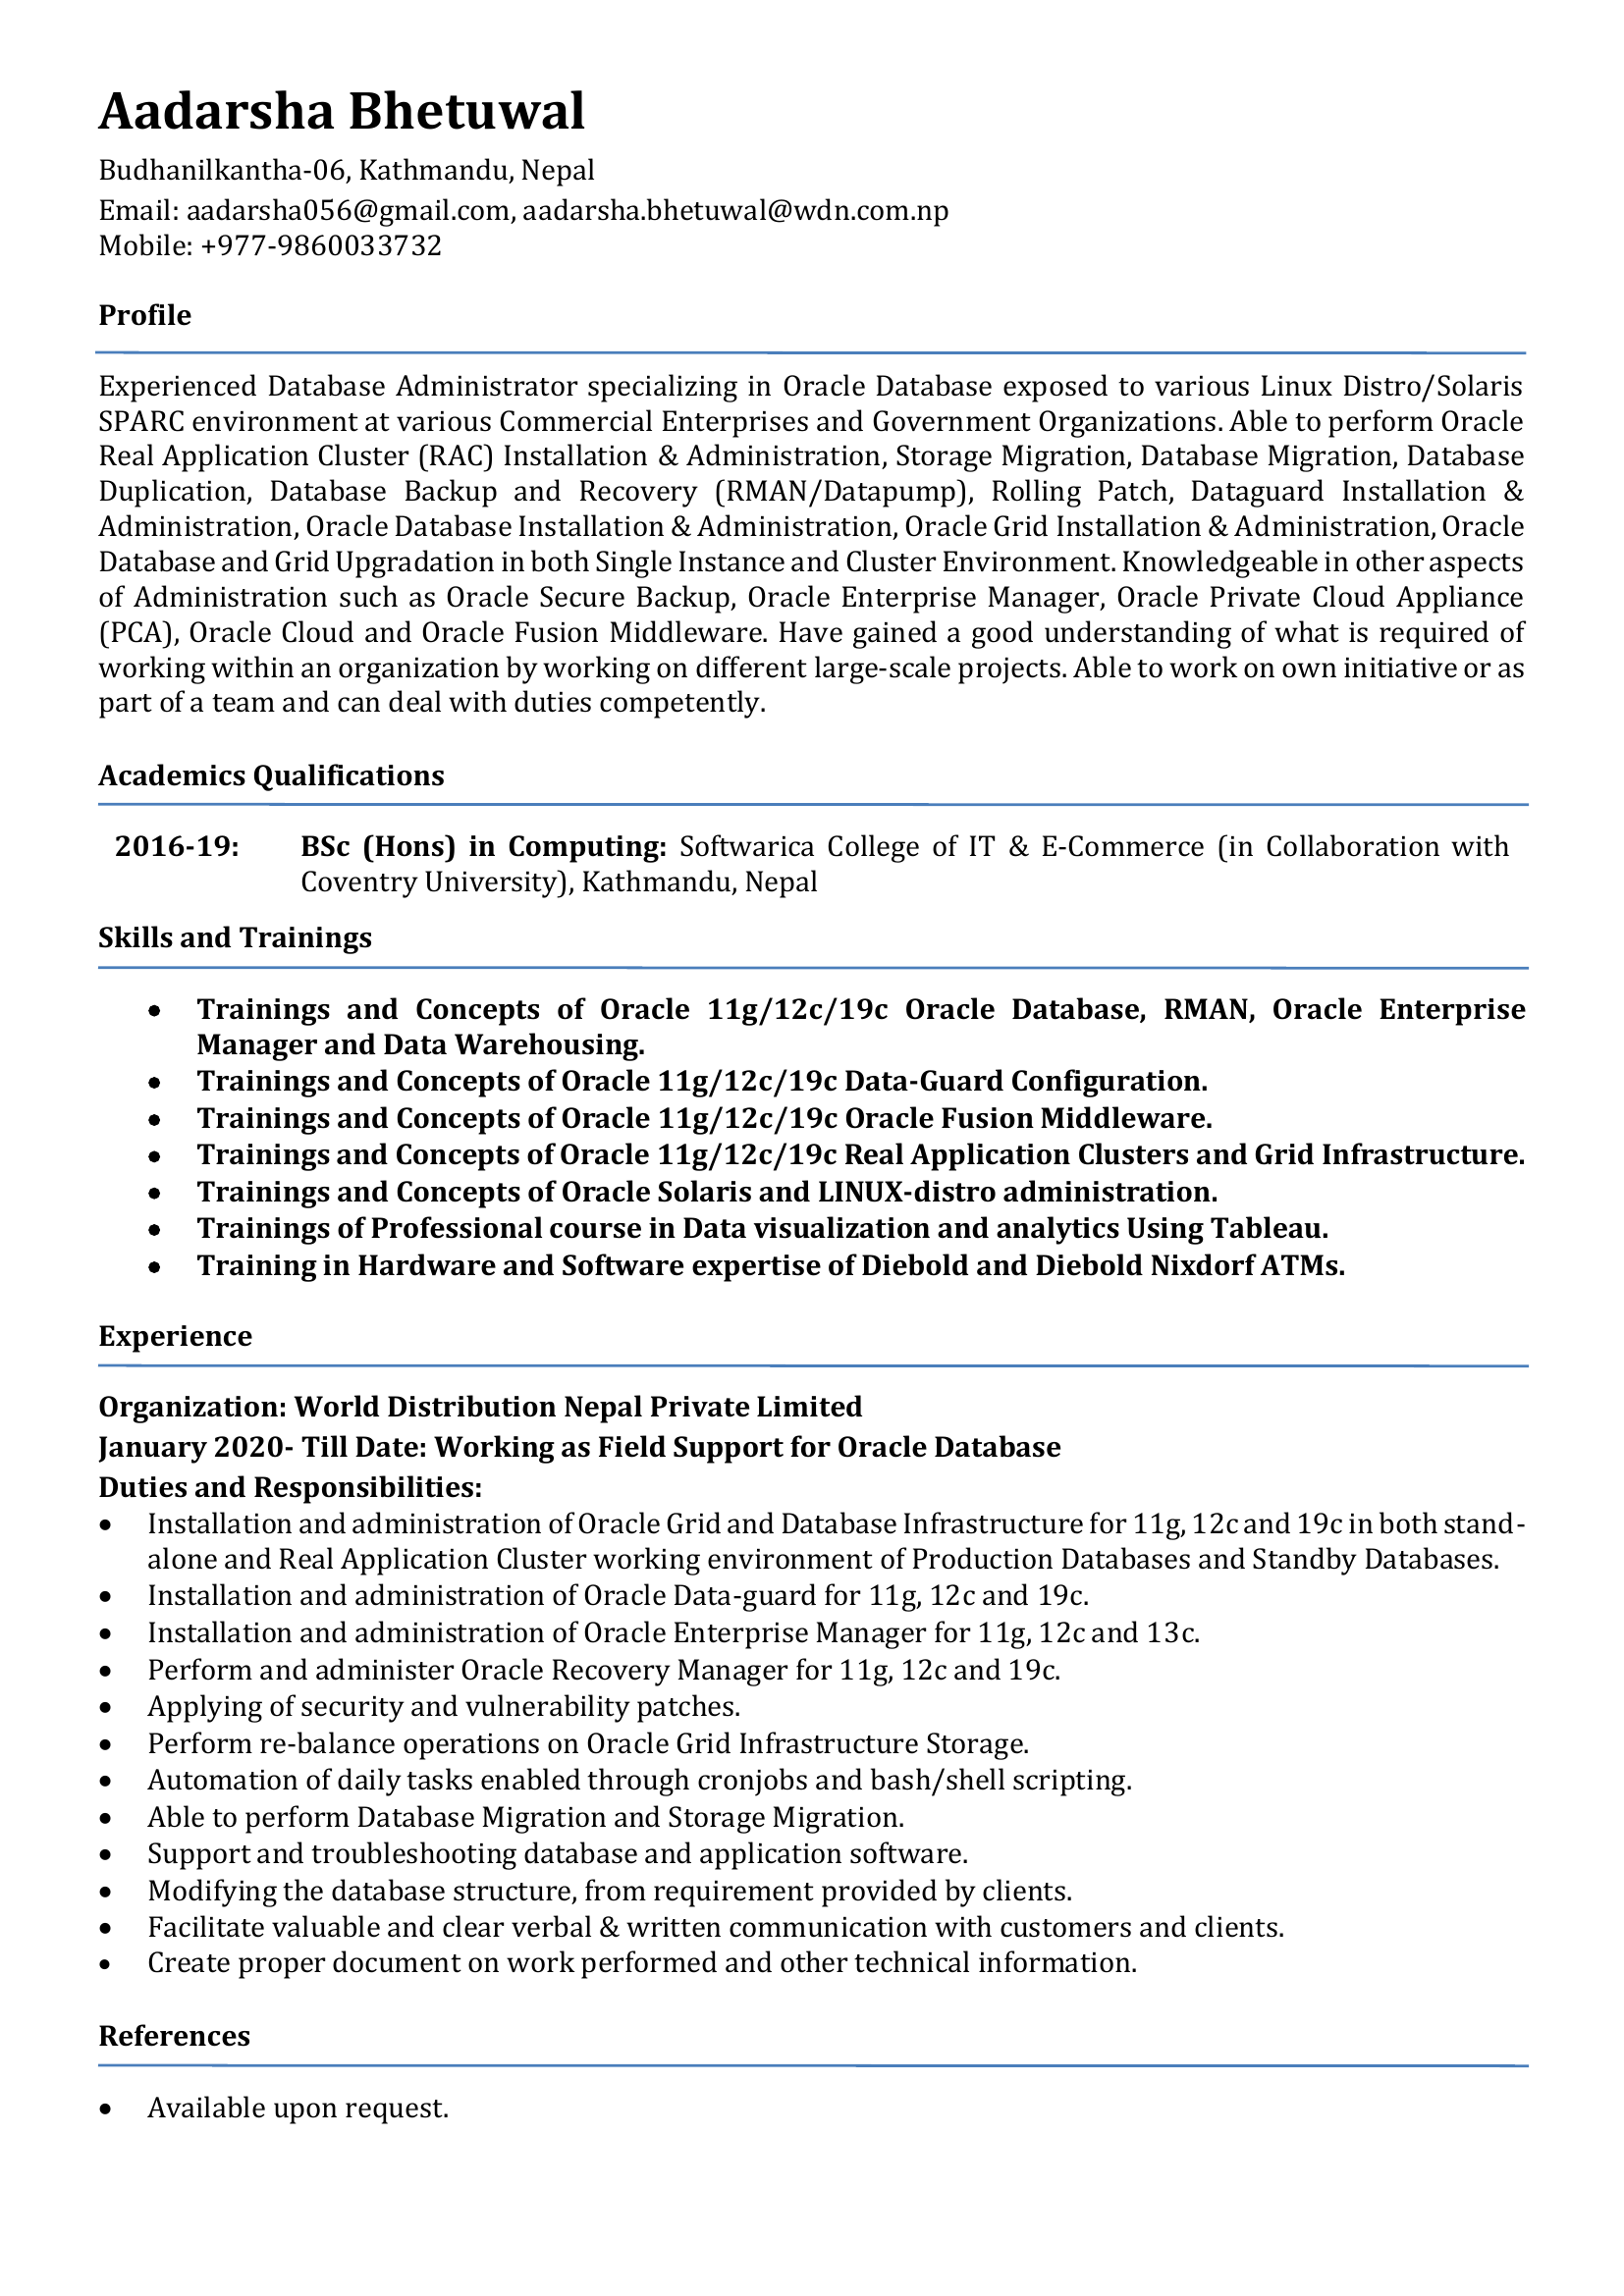

In [ ]:
from pdf2image import convert_from_path
images = convert_from_path('/content/gdrive/MyDrive/ANN-assignment/dataset/aadarsha-cv.pdf')

images[0]


0: 640x480 6 blocks, 109.0ms
Speed: 3.4ms preprocess, 109.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


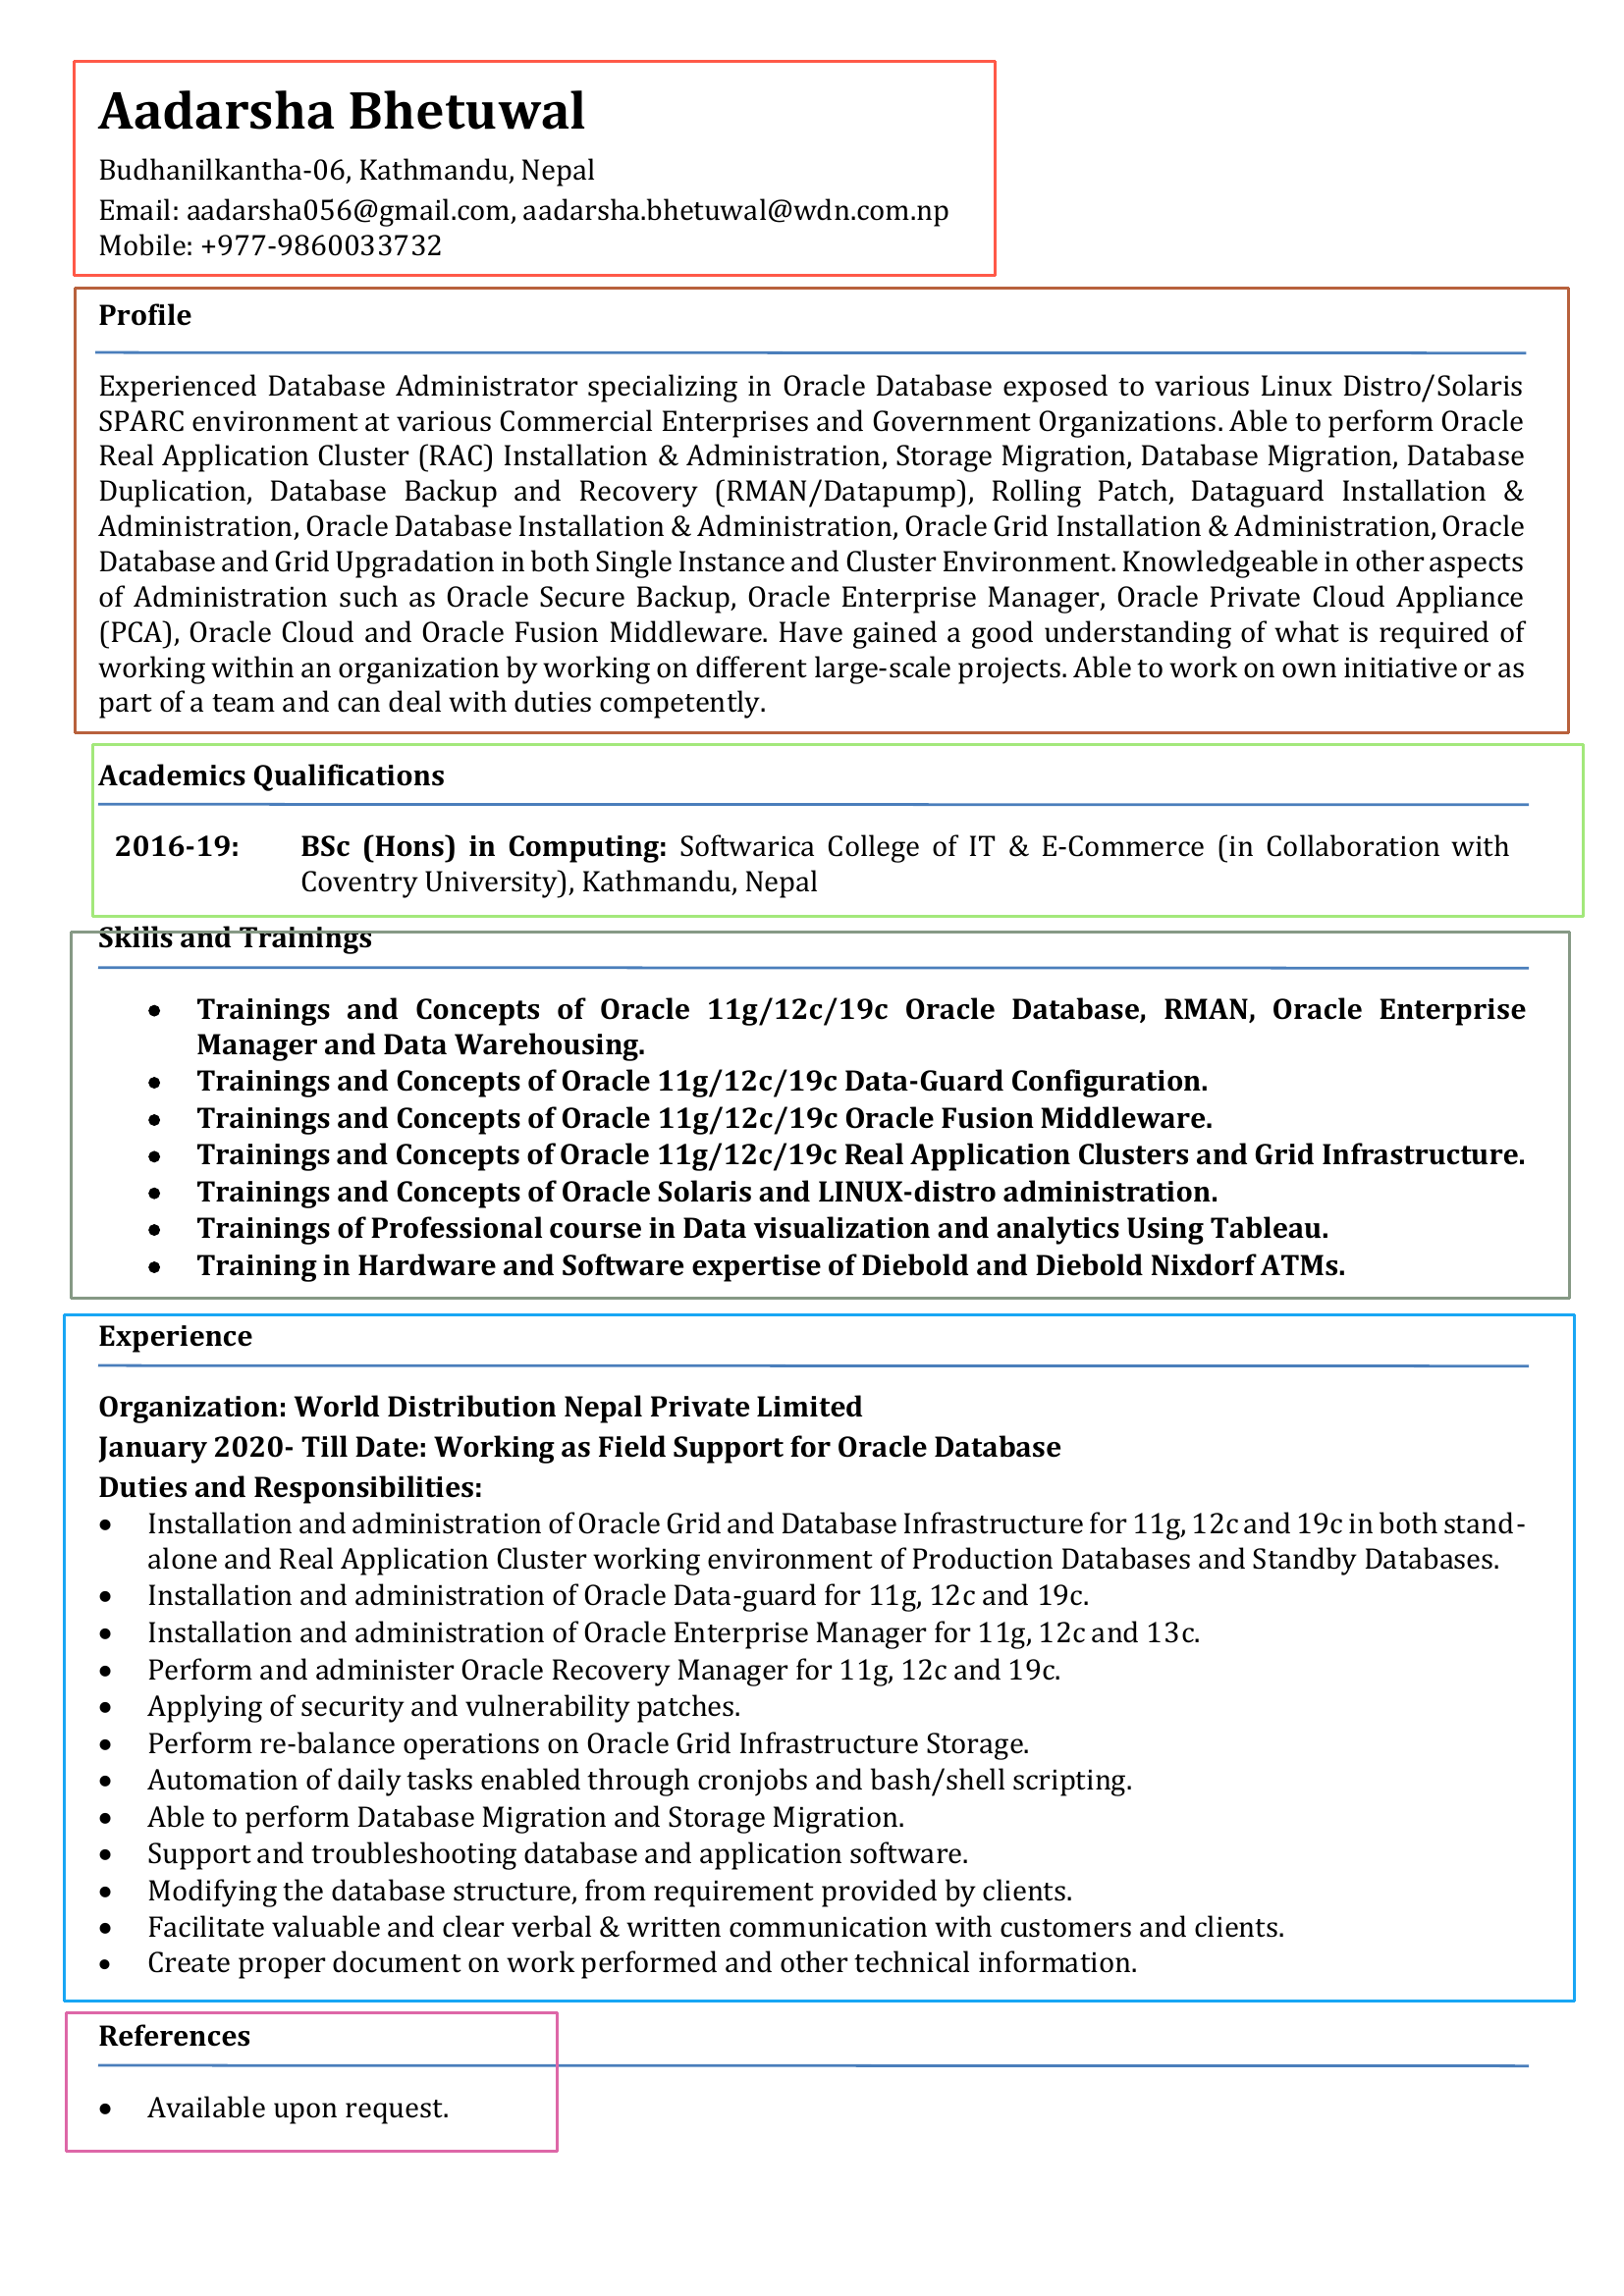

[['Experience',
  'Organization: World Distribution Nepal Private Limited',
  'January 2020- Till Date: Working as Field Support for Oracle Database',
  'Duties and Responsibilities:',
  'Installation and administration of Oracle Grid and Database Infrastructure for',
  '12cand 19c in both stand -',
  'alone and Real Application Cluster working environment of Production Databases and Standby Databases',
  'Installation and administration of Oracle Data-guard for 1lg, 12c and 19c.',
  'Installation and administration of Oracle Enterprise Manager for 11g, 12cand 13c',
  'Perform and administer Oracle Recovery Manager for 11g, 12c and 19c',
  'Applying of security and vulnerability patches',
  'Perform re-balance operations on Oracle Grid Infrastructure Storage',
  'Automation of daily tasks enabled through cronjobs and bash/shell scripting:',
  'Able to',
  'perform Database Migration and Storage Migration.',
  'Support and troubleshooting database and application software:',
  'Modifyin

In [ ]:
image_np = np.array(images[0])

img = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

# cv2_imshow(img)
annotImg, result = getAnnotatedImageAndResult(img)

cv2_imshow(annotImg)
result

As we can see in the both two completely fresh resume, our model can successfully identify the regions of the dataset. This data can be further used for various types of screening and analytics.  